# Lookalike Model

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

customers = pd.read_csv('./Customers.csv')
products = pd.read_csv('./Products.csv')
transactions = pd.read_csv('./Transactions.csv')

## Prepare the Data

In [3]:
merged_df = transactions.merge(customers, on='CustomerID', how='left')
merged_df = merged_df.merge(products, on='ProductID', how='left')

## feature set for each customer

In [4]:
customer_features = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Category': lambda x: x.mode()[0]  # Most frequent category
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'NumTransactions',
    'Category': 'PreferredCategory'
}).reset_index()
print(customer_features.head())

  CustomerID  TotalSpending  NumTransactions PreferredCategory
0      C0001        3354.52                5       Electronics
1      C0002        1862.74                4          Clothing
2      C0003        2725.38                4        Home Decor
3      C0004        5354.88                8             Books
4      C0005        2034.24                3       Electronics


## Encode Categorical Data

### Encode the PreferredCategory column using one-hot encoding

In [5]:
customer_features = pd.get_dummies(customer_features, columns=['PreferredCategory'])

## Calculate Similarity

### cosine similarity to find similar customers

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(customer_features.iloc[:, 1:])  # Exclude CustomerID
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=customer_features['CustomerID'],
    columns=customer_features['CustomerID']
)
print(similarity_df.head())

CustomerID  C0001  C0002  C0003  C0004  C0005     C0006     C0007     C0008  \
CustomerID                                                                    
C0001         1.0    1.0    1.0    1.0    1.0  1.000000  1.000000  1.000000   
C0002         1.0    1.0    1.0    1.0    1.0  0.999999  0.999999  1.000000   
C0003         1.0    1.0    1.0    1.0    1.0  1.000000  1.000000  1.000000   
C0004         1.0    1.0    1.0    1.0    1.0  1.000000  1.000000  1.000000   
C0005         1.0    1.0    1.0    1.0    1.0  1.000000  1.000000  0.999999   

CustomerID     C0009     C0010  ...  C0191  C0192     C0193  C0194  C0195  \
CustomerID                      ...                                         
C0001       0.999998  0.999999  ...    1.0    1.0  1.000000    1.0    1.0   
C0002       0.999999  1.000000  ...    1.0    1.0  0.999999    1.0    1.0   
C0003       0.999998  0.999999  ...    1.0    1.0  1.000000    1.0    1.0   
C0004       0.999998  0.999999  ...    1.0    1.0  1.000000  

## Using the customer_features DataFrame from the previous task

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.iloc[:, 1:])

## Apply Clustering

### KMeans clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

db_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, clusters)
    db_scores.append((n_clusters, db_score))

optimal_clusters = min(db_scores, key=lambda x: x[1])
print(f"Optimal Clusters: {optimal_clusters[0]}, DB Index: {optimal_clusters[1]}")

Optimal Clusters: 5, DB Index: 0.7040079101394886


## Train Final Model

### Train the KMeans model with the optimal number of clusters

In [9]:
final_kmeans = KMeans(n_clusters=optimal_clusters[0], random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

## Visualize the Clusters

### PCA for dimensionality reduction and visualize clusters

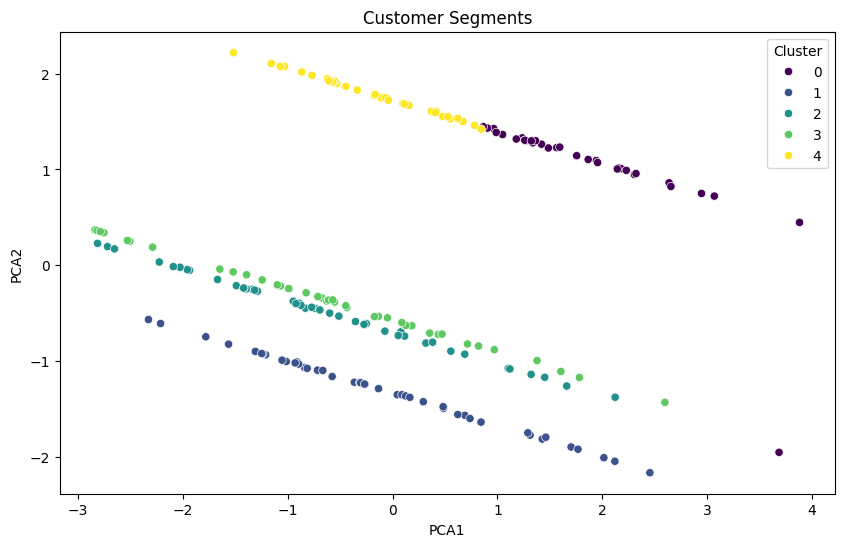

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
customer_features['PCA1'] = reduced_features[:, 0]
customer_features['PCA2'] = reduced_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='viridis'
)
plt.title('Customer Segments')
plt.show()

## Save the Results

In [11]:
customer_features[['CustomerID', 'Cluster']].to_csv('FirstName_LastName_Clustering.csv', index=False)
